In [43]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

In [6]:
df = pd.read_csv('data/cleaned_data.csv', index_col=0)

In [7]:
df

,floor,ground-floor,1-floor,2-floor,3-floor,emotion,comfort,occupation,usage,recruitment
1,NaN,NaN,NaN,NaN,NaN,I always feel a bit zen when I am here. It’s q...,"The light in the offices is perfect, as well a...",NaN,Yes,I will be only be participating in the survey
2,NaN,NaN,NaN,NaN,NaN,"Cold, a bit down","Temperature (it’s too cold), lack of light (bu...",NaN,Yes,I will be only be participating in the survey
3,NaN,NaN,NaN,NaN,NaN,Calm,Comfortable temperature and pleasant lighting....,NaN,Yes,I will be only be participating in the survey
4,6th Floor,NaN,NaN,NaN,NaN,"Hungry, a bit cold","Cold, quiet, well lit",NaN,Yes,I would like to participate in a building walk
5,Ground floor,Library learning room,NaN,NaN,NaN,Stressed about my exams but I am happy in this...,Usually it is really nice and comfortably warm...,Yes,Yes,I would like to participate in a building walk
...,...,...,...,...,...,...,...,...,...,...
79,Ground floor,Round tables by the three plants (across woode...,NaN,NaN,NaN,Neutral,NaN,NaN,NaN,NaN
80,Ground floor,Next to the lockers,NaN,NaN,NaN,Neutral,NaN,NaN,NaN,NaN
81,3rd Floor,NaN,NaN,NaN,Near the printer,NaN,NaN,NaN,NaN,NaN
82,2nd Floor,NaN,NaN,Unsure,NaN,NaN,NaN,NaN,NaN,NaN


# Basic Statistics

74 respondents provided their location, of which 61 shared their emotional state and 57 their comfort. This is likely because the terms comfort and emotions were kept purposefuly vague and therefore may have discouraged responses. 

Most respondents were found on the first floor. Across all floors, majority of the responses were provided by students in the library learning rooms with individual desks for learning. Being in a non-social setting possibly allowed students to (a) respond to our survey, and (b) find it important to reflect upon their physical and emotional states. 

The most commonly reported emotion was `calm` and comfort was `OK`. 

In [9]:
df.describe()

,floor,ground-floor,1-floor,2-floor,3-floor,emotion,comfort,occupation,usage,recruitment
count,74,14,28,12,9,61,57,58,62,61
unique,7,5,6,3,3,55,55,2,2,2
top,1st Floor,Library learning room,Library learning room,Library learning room,Open lounge area,Calm,Ok,Yes,Yes,I will be only be participating in the survey
freq,29,5,7,9,5,3,2,48,54,44


# Students Across the Floors

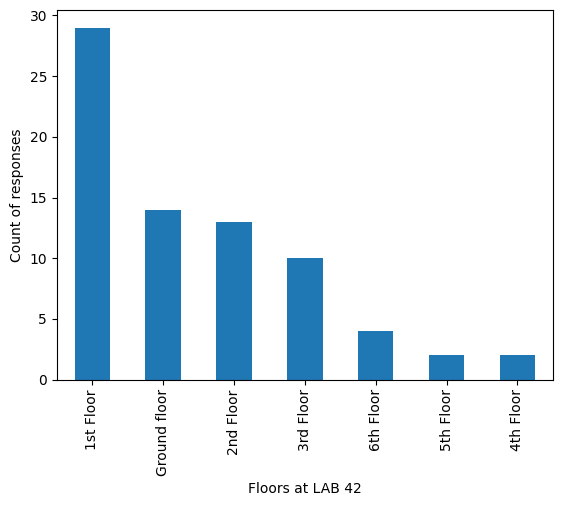

In [58]:
df.floor.value_counts().plot.bar()
plt.ylabel("Count of responses")
plt.xlabel("Floors at LAB 42")
plt.savefig('plots/floors-responses.jpg', dpi=300, bbox_inches=None)

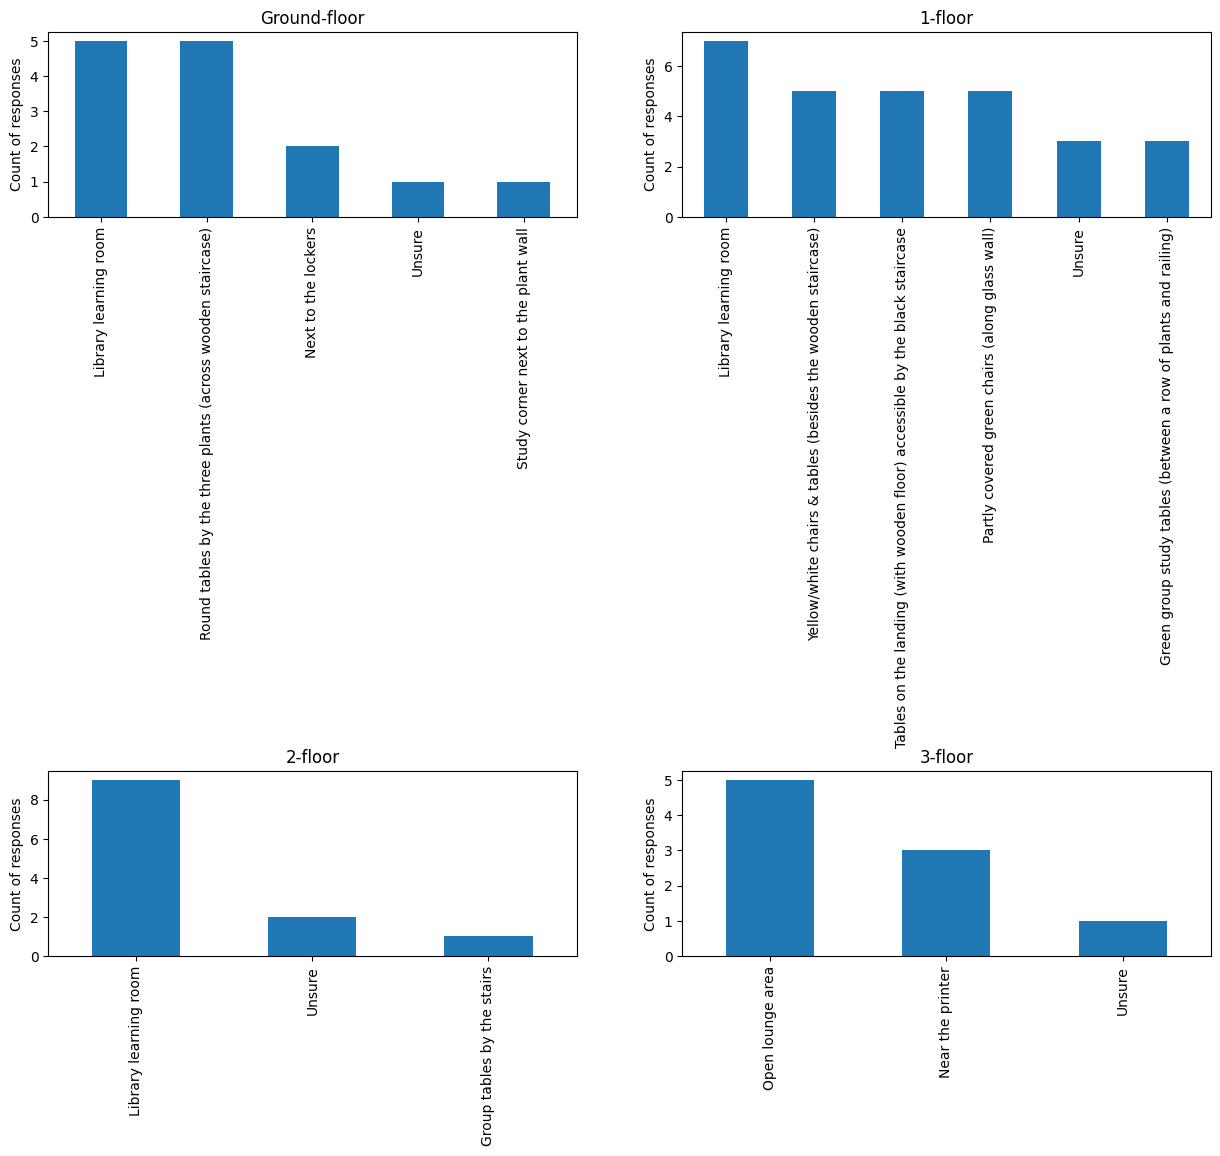

In [94]:
def plot_responses_rooms(floor, n):
    ax = plt.subplot(2, 2, n + 1)
    df[floor].value_counts().plot.bar(ax=ax)
    plt.ylabel("Count of responses")
    plt.title(floor.capitalize())

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=3)
floors = ['ground-floor', '1-floor', '2-floor', '3-floor']

for n, floor in enumerate(floors):
    plot_responses_rooms(floor, n)

plt.savefig('plots/spaces-per-floor.jpg',
            dpi=300, bbox_inches='tight')

In [41]:
df.emotion.unique()

array(['I always feel a bit zen when I am here. It’s quiet when I need it and noisy when I want it. For instance, there are now students presenting downstairs. It brings some vibrance without being too noisy.',
       'Cold, a bit down', 'Calm', 'Hungry, a bit cold',
       'Stressed about my exams but I am happy in this room. It’s energising but with a cool calm aesthetic ',
       'Calm, motivated', 'Too open, so a bit anxious', 'cold, cramped',
       'Normal', 'Peaceful, quiet, stressed due to work ',
       'Neutral, happy', 'Stable, calm', 'Comfy, decluttered, peaceful',
       nan, 'Relaxed, calm', 'Little bit tiredafter a day of studying',
       'opressed', 'tired, no motivation, hungry', 'Relaxed',
       'NEED LIGHTING AT THIS SPACE!!! ', 'tired, calm',
       'Calm, peacefull, motivated', 'Chill ', 'Good',
       'Comfortable, getting ready to study', 'Calm, peacefull',
       'Positive vibes', 'Calm. Motivated. ', 'Calm, focused, relaxed',
       'Exposed',
       'Nice an